<a href="https://colab.research.google.com/github/luigiselmi/timeseries/blob/main/traffic_forecast_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metro Interstate Traffic Volume Forecasting (Part 2)
This notebook is based on chapter 13 of the book [*Time Series Forecasting in Python*](https://www.manning.com/books/time-series-forecasting-in-python-book) by Marco Peixeiro. Classical algorithms for time series forecasting, are

* $Moving Average MA(q)$
* $Auto Regressive AR(p)$
* $Autoregressive Moving Average ARMA(p,q)$
* $Autoregressive Integrated Moving Average ARIMA(p,d,q)$
* $SARIMA(p,d,q)(P,D,Q)_m$
* $SARIMAX$

where q is the order, or lag, of the time series, that is the number of previous elements in the series that are used for the forecast, p is the autocorrelation order, that is number of elements that are correlated, P and Q are the seasonal lag and autocorrelation order. These models try to fit a set of basis functions to the data depending on the chosen order $(p,d,q)(P,D,Q)_m$. With the neural networks we fit an unknown nonlinear function to the data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
#import tensorflow as tf
print('NumPy version: %s'%np.__version__)
print('Pandas version: %s'%pd.__version__)
print('Matplotlib version: %s'%mpl.__version__)
#print('TensorFlow versiob: %s'%tf.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.8.4


## Data windowing
In order to train a model we split the data into time windows of the same length, for instance 24 hours. If the task is multistep forecasting, we use e.g. 24 hours as input data and the next 24 hours as target values so that a data window contains 48 hours. For example, the 1st window uses 48 hours starting from the 1st hour, the 2nd window uses 48 hours starting from the 2nd hour and so on. So there is an overlap of 47 hours between two consecutive data windows. We can create batches using a certain number of data windows, e.g. 32 data windows. The order for each data window cannot be changed but the order of the data windows in a batch can be shuffled.

In [2]:
train_df = pd.read_csv('data/metro_interstate_traffic/train.csv', index_col=0)
val_df = pd.read_csv('data/metro_interstate_traffic/val.csv', index_col=0)
test_df = pd.read_csv('data/metro_interstate_traffic/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [5]:
day_enum = ['Friday', 
            'Saturday', 
            'Sunday', 
            'Monday', 
            'Tuesday', 
            'Wednesday', 
            'Thursday', 
            'Friday', 
            'Saturday', 
            'Sunday', 
            'Monday', 
            'Tuesday', 
            'Wednesday', 
            'Thursday',
            'Friday',
            'Saturday', 
            'Sunday']

len(day_enum)

17

We can see the 48 hours data windows within the first 400 hours in our dataset, with square markers and blu color used for the 24 inputs of each data window, and cross markers and red color used for the labels.

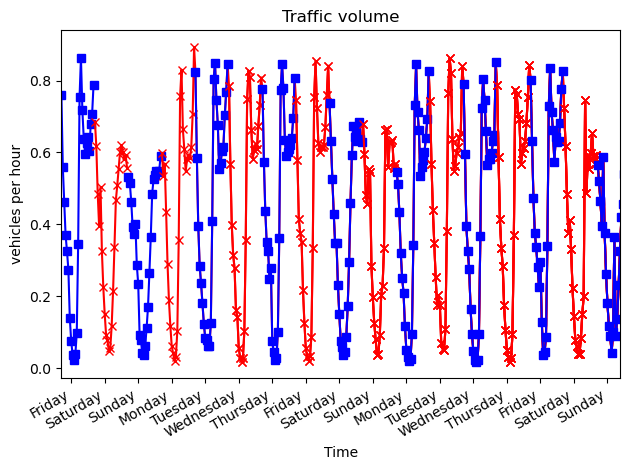

In [8]:
fig, ax = plt.subplots()
fig.autofmt_xdate()

for n in range(0, 17, 2):
    start = 24 * n
    stop = 24 * (n + 1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')

ax.set_title('Traffic volume')
ax.set_xlabel('Time')
ax.set_ylabel('vehicles per hour')
plt.xticks(np.arange(start=7, stop=400, step=24), day_enum)
plt.xlim(0, 400)
plt.tight_layout()

## Deep learning model
Deep learning model might perform better than classical time series models when the dataset available is large and contains signals that are complex. For example SARIMAX can be used only when there is only one kind of seasonality or cycle. In general deep learning model can be used when there is some nonlinear relationship between the input, in our example the meteorological variables and holidays and the target.  

In [3]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result